Bu eğitici, bir Üretken Çekişmeli Ağı (Deep Convolutional Generative Adversarial Network - DCGAN) sıfırdan yazarak, el yazısı rakamların görüntülerinin nasıl oluşturulacağını TensorFlow kütüphanesi kullanarak göstermektedir. İlk defa https://arxiv.org/abs/1406.2661 bağlantısında bulunan makalede önerilen bir GAN modeli olan Vanilla GAN algoritmasını programlayacağız!

İlk olarak, ihtiyacımız olan temel kütüphaneleri içe aktaracağız. Ağı ve çekişmeli süreçleri oluşturmak için TensorFlow 2.0'ı, gürültüyü oluşturmak için NumPy'yi ve görüntüleri kaydetmek için matplotlib'i kullanacağız. Ayrıca TensorFlow 2.0 kullandığınızdan emin olun — aşağıdaki kod daha eski bir TensorFlow versiyonuyla çalışmayacaktır.

In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import time

2.5.0


## Veri kümesini yükleme ve hazırlama

Burada kullanacağımız veri seti, her biri $28\times 28$ piksel boyutunda, elle yazılmış rakamlardan oluşan yaklaşık $60.000$ siyah beyaz görüntüden oluşan Yann LeCunn'un [MNIST veri setidir](http://yann.lecun.com/exdb/mnist/). Bu veri seti, GAN'ların eğitimi için [faydalı olduğu kanıtlanmış bazı faydalı "hack'lere" göre](https://github.com/soumith/ganhacks) ön işleme tabi tutulacaktır. 

Üreteci ve Ayrıştırıcı sinir ağlarını eğitmek için MNIST veri setini kullanacaksınız. Üretici, MNIST verilerine benzeyen el yazısı rakamları üretmeyi öğrenecektir.

İkinci olarak, TensorFlow kütüphanesinde bulunan yerleşik veri kümesini Python ortamına okutalım:

In [2]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
print(f"Eğitim örneklerinin şekli: {train_images.shape}")

Eğitim örneklerinin şekli: (60000, 28, 28)


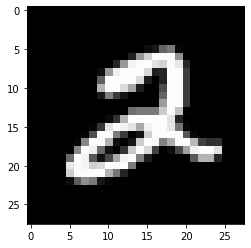

In [24]:
plt.imshow(train_images[5], cmap = "gray")
plt.savefig("2.png")

Daha sonra, uygulama boyunca ihtiyaç duyduğumuz bazı global değişkenleri tanımlamamız gerekiyor. `batch_size` parametresi, sinir ağlarında aynı anda kaç örneğin beslendiğini tanımlar. Mükemmel karıştırma (shuffle) için `buffer_size` parametresini eğitim veri setinin uzunluğuna eşit olarak ayarladık. Farklı bir mini-yığın büyüklüğü veya veri seti kullanmak istiyorsanız, bu değişkenleri ayarlamayı unutmayınız

Burada aynı zamanda, yoksa, eğitim sırasında Üretici sinir ağının çıktısını `output_dir` isimli dizine kaydedeceğiz. böylelikle, eğitim ilerledikçe, parametreleri değişen Üretici sinir ağının gerçek görüntülere benzer resimler elde edip etmediğini kontrol edebileceğiz. 

In [5]:
buffer_size= 60000
batch_size = 256
output_dir = "img" 

# Just to make sure the output directory exists..
import os
if not os.path.exists(output_dir ):
    os.makedirs(output_dir )

Okuttuğumuz eğitim verilerini önce bir ön işleme tabii tutalım. Spesifik olarak, $[0, 255]$ aralığındaki girdi değerleri $-1$ ile $1$ arasında normalize edelim. Bu, $0$ değerinin $-1$ ile, $255$ değerinin $1$ ile eşleneceği ve benzer şekilde aradaki tüm değerlerin $[-1, 1]$ aralığında bir değer alacağı anlamına gelir.

Ön-işlemeden sonra, sinir ağlarını gerçekleştirmeden koymadan önce, verileri bir `tf.data.Dataset` nesnesine gönderelim. Bir `tf.data.Dataset`, her elemanın bir veya daha fazla Tensor nesnesi içerdiği bir elemanlar sekansını (sequence of elements) temsil eder. Bu `tf.data.Dataset`nesnesi, resimlerinizi toplu olarak depolamak ve daha sonra bu resimler üzerinde döngü (loop) gerçekleştirmek için bir yineleyici (iterator) olarak kullanılır.

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Görüntüleri [-1, 1] aralığına normalize edelim

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

2022-01-18 20:49:21.982116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Hem Üretici sinir ağını hem de Ayrıştırıcı sinir ağını oluşturmak için `tf.keras` Model Alt-sınıflama API'si (Model Subclasssing API) kullanacağız, bu da bize modelleri oluştururken biraz daha esneklik sağlayacaktır. Subclassing API kullanmak, hem ayrıştırıcı (discriminator) hem de Üretici (generator) için bir sınıf (class) oluşturacağımız anlamına gelir. Bu sınıfların kurucusunda (constructor) sinir ağlarının katmanlarını ve çağrı (call) metodunda modelin ileri beslemesini (forward pass) tanımlayacağız.

## üretici Sinir Ağı

Üretici sinir ağına, 100 boyutlu bir gürültüyü girdi olarak vereceğiz ve 784 boyutunda (düzleştirilmiş (flattened)) bir vektörü çıktı olarak alacağız. Analizin ilerleyen aşamasında bu çıktı vektörünü $28\times 28$ boyutunda (görüntülerin orijinal boyutu) bir matrise yeniden şekillendireceğiz.

Rastgele gürültü yaratmamıza izin veren bir fonksiyona da ihtiyacımız var. Rastgele gürültü, [bu bağlantıda](https://github.com/soumith/ganhacks) önerildiği gibi ortalama 0 ve varyans 1 olan normal bir dağılımdan örneklenecektir.

In [7]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = 100):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 256)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.output_layer = keras.layers.Dense(units=784, activation = "tanh")
        
    def call(self, input_tensor):
        ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return  self.output_layer(x)
    
    def generate_noise(self,batch_size, random_noise_size):
        return tf.random.normal(shape = (batch_size, random_noise_size), mean=0.0, stddev=1.0)

### Sahte Bir Görüntü Oluşturma

İlk olarak `Generator` sınıfı için bir örnek oluşturalım. Daha sonra, bir sahte resim örneği oluşturmak üzere, Normal dağılımdan bir gürültü yaratalım ve bu gürültüyü Üretici Sinir ağına bir kereliğe ileri besleyelim (one forward pass) ve çıktısını görüntüleyelim.

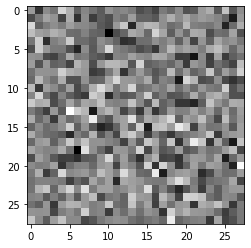

In [8]:
generator = Generator()
noise = tf.random.normal([1, 100])
fake_image  = generator(noise, training=False)
reshaped_fake_image = tf.reshape(fake_image, shape = (28,28))
plt.imshow(reshaped_fake_image, cmap = "gray")

## Optimizasyon

Burada her iki sinir ağı için optimizasyon algoritması olarak Adam'ı kullanacağız. İstediğiniz diğer optimize edicileri kullanmaktan çekinmeyiniz. Öğrenme oranı olarak $0,0002$ kullanılmıştır. Önerilen bu öğrenme oranı, bu görev için mutlaka en uygun değer olmasa da, birkaç değerle test edildikten sonra elde edilmiştir.

In [9]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0002)

## Kayıp Fonksiyonları

Bu kayıp fonksiyonunu kullanarak bir GAN modelinin kayıp fonksiyonunun nasıl bulunduğunu [bir önceki blog yazısında](https://mmuratarat.github.io/turkish/2022-01-16/GANs_in_details) göstermiştik:
    
$$
\min_{\theta_{g}} \max_{\theta_{d}}\,\, V(G_{\theta_{g}}, D_{\theta_{d}}) = E_{x \sim p_{data}} \left[ \log \left( \underbrace{D_{\theta_{d}} (x)}_{\text{gerçek veri $x$ için Ayrıştırıcı'nın çıktısı}} \right) \right] + E_{z \sim p_{z}} \left[ \log \left( 1 - \underbrace{D_{\theta_{d}} \left( G_{\theta_{g}}(z)\right)}_{\text{üretilmiş sahte veri $G_{\theta_{g}} (z)$ için Ayrıştırıcı'nın çıktısı}} \right) \right] 
$$

Bu görev için kullanacağımız kayıp fonksiyonu İkili Çapraz Entropi Kaybı (Binary Cross Entopy Loss) olarak adlandırılır. İkili çapraz entropi kayıp fonksiyonunun denklemi aşağıda verilmiştir:

$$a
L(\theta) = - \frac{1}{n} \sum_{i=1}^{n}  \left[y_{i} \log (\hat{y}_{i}) + (1-y_{i}) \log (1- \hat{y}_{i}) \right]
$$

Burada, $\hat{y}$, model tarafından tahmin edilen etikettir ve $y$, gerçek etikettir. Bu nedenle Hem Üretici hem de Ayrıştırıcı kayıp fonksiyonu için TensorFlow'un `tf.keras.losses.BinaryCrossentropy` fonksiyonunu kullanacağız. Spesifik olarak, her mini-yığın için hesaplanan kaybın ortalamasını alacağız.

Yukarıdaki ikili çapraz entropi kaybı fonksiyonunda, $\hat{y}_{i} = D_{\theta_{d}} (x_{i})$ ve $y_{i} = 1$ olarak değiştirirsek, gerçek resimlere ait kaybı elde ederiz. Benzer şekilde, $\hat{y}_{i} = D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i})\right)$ ve $y_{i} = 0$ olarak değiştirirsek, sahte resimlere ait kaybı elde ederiz. Böylelikle Ayrıştırıcı için kayıp fonksiyonu şu şekil yazılabilir:

$$
\frac{1}{n} \sum_{i=1}^{n} \left[ \log \left( D_{\theta_{d}} (x_{i}) \right) + \log \left(1 - D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i})\right) \right) \right]
$$

Bir GAN modelinin matematiksel modelinden bahsettiğimiz [bir önceki blog yazısında](https://mmuratarat.github.io/turkish/2022-01-16/GANs_in_details) dediğimiz gibi Ayrıştırıcı kayıp fonksiyonu gradyan çıkış (gradient ascent) algoritması ile maksimize edilmelidir. Ancak, TensorFlow ve diğer bir çok Derin Öğrenme kütüphanesi, bir fonksiyonu maksimize etmek yerine, genellikle minimize eder. Bir fonksiyonu maksimize etmek, onun negatifini minimize etmeye eşdeğerdir. Ancak, yukarıda da görüleceği üzere, ikili çapraz entropi kayıp fonksiyonunun başında bir negatif (`-`) işareti vardır. Bu nedenle, Ayrıştırıcı kayıp fonksiyonunu minimize ederken endişelenmemize gerek yoktur.

Üretici kayıp fonksiyonu ise aşağıdaki gibi verilmiştir:

$$
\frac{1}{n} \sum_{i=1}^{n} \left[ \log \left(1 - D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i})\right) \right) \right]
$$

[Bir önceki blog yazısında](https://mmuratarat.github.io/turkish/2022-01-16/GANs_in_details) söylediğimiz gibi, $\log \left(1 - D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i})\right) \right)$ fonksiyonunu minimize etmek yerine, $D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i}) \right)$ fonksiyonunu maksimize ederek Üretici sinir ağını eğitmek, eğitimin başlarında çok daha güçlü gradyanlar sağlayacaktır. Bu nedenle, $D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i}) \right)$ fonksiyonu gradyan çıkış (gradient ascent) algoritması ile maksimize edilmelidir. Yukarıda da bahsettiğimiz gibi, bir fonksiyonu maksimize etmek, onun negatifini minimize etmeye eşdeğerdir. İkili çapraz entropi kayıp fonksiyonunun başında bir negatif (`-`) işareti vardır. Bu nedenle, Üretici kayıp fonksiyonunu minimize ederken endişelenmemize gerek yoktur. Üretici tarafından üretilmiş resimlerin tahmini için $\hat{y}_{i} = D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i})\right)$ ve Üretici gerçek görüntüler ürettiğini düşündüğü için $y_{i} = 1$ olarak yukarıdaki ikili çapraz entropi kayığ fonksiyonunda yerine yazarsak, minimize edilecek kayıp fonksiyonu kolaylıkla bulunabilir:

$$
\frac{1}{n} \sum_{i=1}^{n} \left[ \log \left(D_{\theta_{d}} \left( G_{\theta_{g}}(z_{i})\right) \right) \right]
$$


## Üretici Kayıp Fonksiyonu

Burada önemli olan Üretici gerçek görüntüler ürettiğini düşündüğü için, burada önemli olan, sahte resimlerin Ayrıştırıcı sinir ağından çıktısı ve "gerçek" etiketlerin (yani $y=1$) işin içine dahil edilmesidir, bu nedenle, `tf.ones_like` fonksiyonu kullanılır. Burada, `tf.ones_like` fonksiyonu, girdiyle aynı şekle sahip "birler"den oluşan bir tensör oluşturur.

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx) 

## Ayrıştırıcı Kayıp Fonksiyonu

Burada önemli olan, gerçek resimlerin etiketlerinin 1, sahte resimlerin etiketlerinin 0 olmasıdır. Buna ek olarak, bu iki Ayrıştırıcı kaybı birlikte toplayarak, Ayrıştırıcı için toplam mini-yığın kaybını elde ederiz. Uygulamada, gradyanları ayrı ayrı hesaplayacağız ve ardından bu gradyanları birlikte güncelleyeceğiz.

Ek olarak, aşırı uyumu (overfitting) engellemek için gerçek resimlere ait kayıp fonksiyonuna bir yumuşatma çarpanı(smoothing factor) ekliyoruz.

In [11]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0. 
    total_loss = real_loss + fake_loss
    
    return total_loss

Ayrıştırıcı ağ, Üretici ağa benzer bir şekilde gerçekleştirilir. Tek fark, 784 ($28\times 28 = 784$) boyutlu bir vektörü girdi olarak almamız ve girdinin sahte mi yoksa gerçek mi bir resim olduğunu bize söyleyen yalnızca bir nöron çıktısı vermemizdir.

In [12]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        
        #Layers
        self.input_layer = keras.layers.Flatten()
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 128)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        
        self.logits = keras.layers.Dense(units = 1)  # Bu sinir hücresi, girdinin gerçek mi sahte mi olduğunu söyler.
        
    def call(self, input_tensor):
          ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        x = self.logits(x)
        return x

Şimdi `Discriminator` sınıfı için bir örnek oluşturalım:

In [13]:
discriminator = Discriminator()

Bir sonraki adım, tek bir eğitim adımında ne gerçekleşmesi gerektiğini tanımlamaktır. Üretici ve Ayrıştırıcı'nın gradyanlarını kullanarak her iki ağı da aynı anda eğitiyoruz. İlk olarak, daha önce tanımladığımız yığın büyüklüğüne (batch size) göre bir miktar gürültü üretilir. Daha sonra gerçek resmi ve sahte resmi Ayrıştırıcı'ya besliyoruz ve toplam kaybı hesaplıyoruz. Son adım olarak Üretici için aynısını yapıyoruz ve bu gradyanları uyguluyoruz:

In [14]:
@tf.function()
def training_step(generator: Generator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 32):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, 100) #Gürültü üret
            g_z = generator(noise) # Bu gürültüyü Üretici sinir ağından geçir
            d_x_true = discriminator(images) # Gerçek resimleri Ayrıştırıcı sinir ağından geçir
            d_x_fake = discriminator(g_z) # Üretici çıktısını Ayrıştırıcı sinir ağından geçir

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake) # Ayrıştırıcı için kaybı hesapla
            # Ayrıştırıcı'nın gradyanını ayarla
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            
              
            generator_loss = generator_objective(d_x_fake) # Üretici için kaybı hesapla
            # Üretici'nin gradyanını ayarla
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 

Son adım, tüm eğitimi tanımlayan bir fonksiyon tanımlamaktır. `tf.data.Dataset` nesnesi sayesinde verilerimizi kolayca yineleyebiliriz. Son fonksyion, oluşturulan tüm görüntüleri her 50. epokta bir `OUTPUT_DIR` değişkeninde tanımladığınız dizine kaydedecektir:

In [15]:
# eğitim için biraz gürültü üretelim
seed = tf.random.normal(shape = (1, 100), mean=0.0, stddev=1.0) 

def training(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset: 
            training_step(generator, discriminator, image_batch, batch_size = batch_size, k = 1)
            
        print ('Epok {} için geçen zaman {} sec'.format(epoch + 1, time.time()-start))
        
        #Her 50 epokta bir üretici tarafından oluşturulan sahte görüntüyü kaydedelim:
        if (epoch % 50) == 0: 
            fake_image = tf.reshape(generator(seed), shape = (28, 28))
            print("{}/{} epok, görüntü kaydedildi.".format(epoch + 1, epochs))
            #plt.imshow(fake_image, cmap = "gray")
            plt.imsave("{}/{}.png".format(output_dir, epoch + 1), fake_image, cmap = "gray")


Tüm fonksiyonlarımızı tanımladıktan sonra, artık Vanilla GAN algoritmamızı çalıştırmaya hazırız. Burada algoritmayı 300 epok defa çalıştırdık ancak dilerseniz, daha iyi sonuçlar elde edebilmek için, siz bu sayıyı büyütebilirsiniz.

In [16]:
training(dataset = train_dataset, epochs = 300)

# Epok 1 için geçen zaman 3.7734439373016357 sec
# 1/300 epok, görüntü kaydedildi.
# Epok 2 için geçen zaman 2.799484968185425 sec
# Epok 3 için geçen zaman 2.3485910892486572 sec
# Epok 4 için geçen zaman 2.2635040283203125 sec
# Epok 5 için geçen zaman 2.16536808013916 sec
# Epok 6 için geçen zaman 2.226936101913452 sec
# Epok 7 için geçen zaman 2.5798490047454834 sec
# Epok 8 için geçen zaman 2.2206039428710938 sec
# Epok 9 için geçen zaman 2.073057174682617 sec
# 
# ...
# Epok 297 için geçen zaman 2.3989040851593018 sec
# Epok 298 için geçen zaman 2.295867681503296 sec
# Epok 299 için geçen zaman 2.2671799659729004 sec
# Epok 300 için geçen zaman 2.2600152492523193 sec

2022-01-18 20:49:39.713501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epok 1 için geçen zaman 3.7734439373016357 sec
1/300 epok, görüntü kaydedildi.
Epok 2 için geçen zaman 2.799484968185425 sec
Epok 3 için geçen zaman 2.3485910892486572 sec
Epok 4 için geçen zaman 2.2635040283203125 sec
Epok 5 için geçen zaman 2.16536808013916 sec
Epok 6 için geçen zaman 2.226936101913452 sec
Epok 7 için geçen zaman 2.5798490047454834 sec
Epok 8 için geçen zaman 2.2206039428710938 sec
Epok 9 için geçen zaman 2.073057174682617 sec
Epok 10 için geçen zaman 2.390544891357422 sec
Epok 11 için geçen zaman 2.2875049114227295 sec
Epok 12 için geçen zaman 2.0395760536193848 sec
Epok 13 için geçen zaman 2.2514138221740723 sec
Epok 14 için geçen zaman 2.144766092300415 sec
Epok 15 için geçen zaman 2.6478261947631836 sec
Epok 16 için geçen zaman 2.423539876937866 sec
Epok 17 için geçen zaman 2.59405779838562 sec
Epok 18 için geçen zaman 2.2333641052246094 sec
Epok 19 için geçen zaman 2.212090015411377 sec
Epok 20 için geçen zaman 2.2875640392303467 sec
Epok 21 için geçen zaman 2.4